The purpose of notebook2 is to do deep analysis by examining trader behavior and strategy performance under different sentiments.

Im not focused on building complex models here, but to identifying behavioral patterns, validating strategy and figuring out wether it aligns with sentiment, and assessing risk under various emotional conditions.

*NOTE* - All analyses done in this notebook are based on the feature-engineered dataset generated in notebook1.ipynb.

What I have done in this notebook:

1. Evaluated contrarian vs momentum trading strategies under sentiment regimes
2. Identified trader archetypes and their survival characteristics
3. Analyzed the risk dynamics during extreme fear and extreme greed
4. Validated robustness of insights through controlled stress tests

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [64]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

ROOT = Path.cwd()
DATA_DIR = ROOT / "csv_files"
OUTPUT_DIR = ROOT / "outputs"

df = pd.read_csv(DATA_DIR / "trades_features.csv")


In [65]:
df[[
    "sentiment",
    "sentiment_ordinal",
    "direction",
    "net_pnl",
    "return_usd"
]].isna().mean()

sentiment            0.127642
sentiment_ordinal    0.127642
direction            0.000000
net_pnl              0.000000
return_usd           0.000204
dtype: float64

In [66]:
df["strategy_type"] = pd.Series(index=df.index, dtype="object")

In [67]:
df.loc[
    df["sentiment_ordinal"].notna() &
    (df["sentiment_direction_interaction"] > 0),
    "strategy_type"
] = "momentum"

df.loc[
    df["sentiment_ordinal"].notna() &
    (df["sentiment_direction_interaction"] <= 0),
    "strategy_type"
] = "contrarian"


In [68]:
df["strategy_type"].value_counts(dropna=False)

strategy_type
contrarian    97681
momentum      86582
NaN           26961
Name: count, dtype: int64

In [69]:
strategy_perf = (
    df.dropna(subset=["strategy_type"])
      .groupby("strategy_type")["net_pnl"]
      .agg(mean="mean", median="median", trades="count")
)

strategy_perf

,mean,median,trades
strategy_type,,,
contrarian,71.527589,-0.01189,97681
momentum,35.266619,0.00000,86582


In [70]:
efficiency_perf = (
    df.dropna(subset=["strategy_type"])
      .groupby("strategy_type")["return_usd"]
      .agg(mean="mean", median="median")
)

efficiency_perf

,mean,median
strategy_type,,
contrarian,0.034484,-0.00005
momentum,0.006155,0.00000


In [71]:
by_regime = (
    df.dropna(subset=["strategy_type"])
      .groupby(["sentiment", "strategy_type"])["net_pnl"]
      .mean()
      .unstack()
)

by_regime

strategy_type,contrarian,momentum
sentiment,,
extreme_greed,24.316286,24.572213
fear,56.993385,41.137738
greed,142.964742,11.795231
neutral,21.005251,NaN


<Figure size 900x600 with 0 Axes>

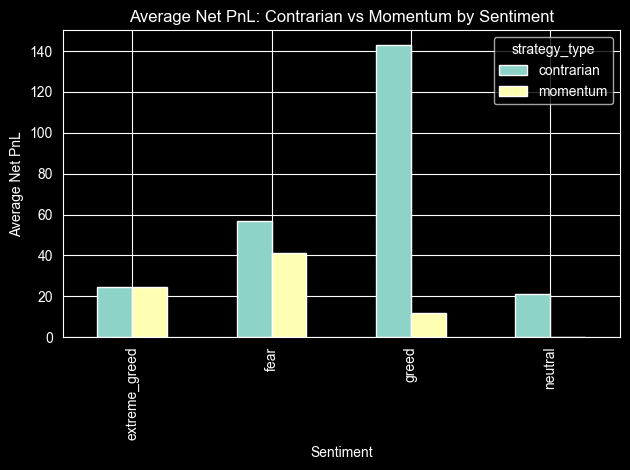

In [72]:
plt.figure(figsize=(9,6))
by_regime.plot(kind="bar")
plt.title("Average Net PnL: Contrarian vs Momentum by Sentiment")
plt.ylabel("Average Net PnL")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "strategy_vs_sentiment.png")
plt.show()

In [73]:
trader_stats = (
    df.groupby("account")
      .agg(
          trade_count=("net_pnl", "count"),
          avg_net_pnl=("net_pnl", "mean"),
          pnl_volatility=("net_pnl", "std"),
          win_rate=("is_profitable", "mean"),
          avg_trade_size=("abs_size_usd", "mean")
      )
      .dropna()
)

In [74]:
trader_stats.describe()

,trade_count,avg_net_pnl,pnl_volatility,win_rate,avg_trade_size
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,6600.750000,96.452886,855.790314,0.397601,6007.929370
std,8250.373724,135.024250,962.658851,0.112947,7281.058575
min,332.000000,-38.467086,68.326272,0.234987,507.626933
25%,1381.750000,8.459296,246.486815,0.325511,2011.069878
50%,3699.000000,40.140921,553.439649,0.371178,3327.972048
75%,8862.500000,146.733751,1303.108238,0.443342,7375.525018
max,40184.000000,520.202678,4690.764320,0.838067,34396.580284


In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(trader_stats)

In [76]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
trader_stats["cluster"] = kmeans.fit_predict(X)

In [77]:
cluster_summary = trader_stats.groupby("cluster").mean()
cluster_summary

,trade_count,avg_net_pnl,pnl_volatility,win_rate,avg_trade_size
cluster,,,,,
0,5044.428571,91.274351,643.890083,0.530688,11033.952645
1,20003.833333,37.992365,408.913329,0.380114,1915.636756
2,1691.600000,364.841030,2536.444649,0.346208,6619.420645
3,3388.000000,28.243755,553.025447,0.356906,5030.367683


In [78]:
trader_stats["cluster"].value_counts()

cluster
3    14
0     7
1     6
2     5
Name: count, dtype: int64

In [79]:
cluster_sentiment_perf = (
    df.merge(
        trader_stats[["cluster"]],
        left_on="account",
        right_index=True,
        how="inner"
    )
    .groupby(["cluster", "sentiment"])["net_pnl"]
    .mean()
    .unstack()
)

cluster_sentiment_perf

sentiment,extreme_greed,fear,greed,neutral
cluster,,,,
0,61.636526,58.573075,80.035080,-325.414090
1,-0.635342,21.994488,93.541055,9.096553
2,-2.876205,431.096520,181.106137,584.464490
3,-19.916180,31.950633,53.702315,-21.874480


In [80]:
cluster_labels = {
    0: "Conservative Traders",
    1: "Overtraders",
    2: "High-Risk Gamblers",
    3: "Aggressive Size Traders"
}
trader_stats["cluster_label"] = trader_stats["cluster"].map(cluster_labels)
trader_stats[["cluster", "cluster_label"]].drop_duplicates()

,cluster,cluster_label
account,,
0x083384f897ee0f19899168e3b1bec365f52a9012,2,High-Risk Gamblers
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3,Aggressive Size Traders
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1,Overtraders
0x2c229d22b100a7beb69122eed721cee9b24011dd,0,Conservative Traders


In [81]:
df = df.merge(
    trader_stats[["cluster_label"]],
    left_on="account",
    right_index=True,
    how="left"
)
df["cluster_label"].value_counts(dropna=False)

cluster_label
Overtraders                120023
Aggressive Size Traders     47432
Conservative Traders        35311
High-Risk Gamblers           8458
Name: count, dtype: int64

In [82]:
cluster_sentiment_perf_labeled = (
    df.dropna(subset=["cluster_label", "sentiment"])
      .groupby(["cluster_label", "sentiment"])["net_pnl"]
      .mean()
      .unstack()
)

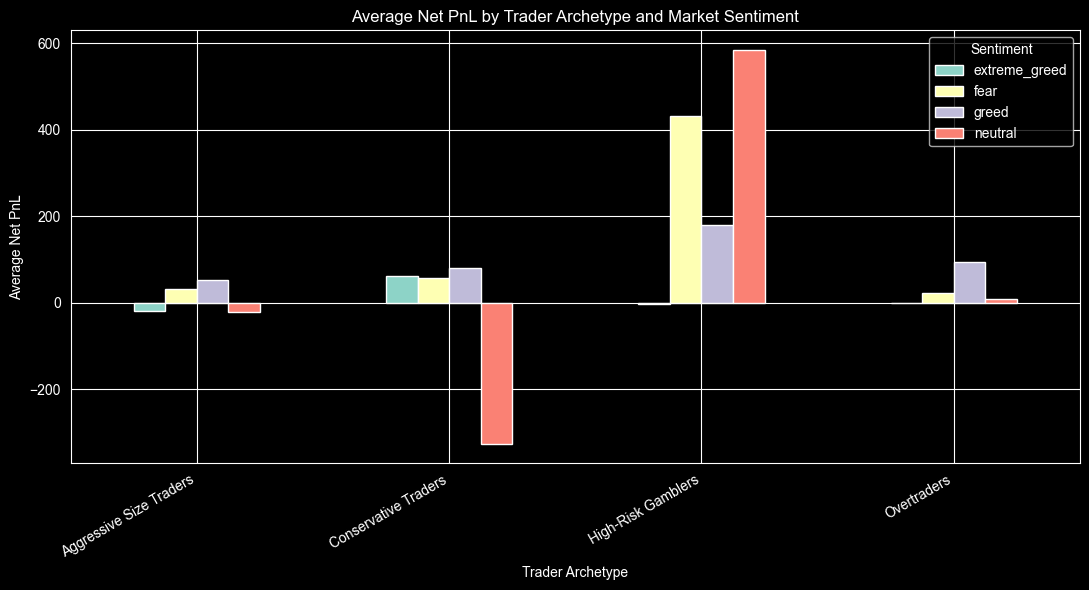

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 6))

cluster_sentiment_perf_labeled.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Average Net PnL by Trader Archetype and Market Sentiment")
plt.xlabel("Trader Archetype")
plt.ylabel("Average Net PnL")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Sentiment")
plt.tight_layout()

plt.savefig(
    OUTPUT_DIR / "cluster_sentiment_pnl_labeled.png",
    dpi=150
)

plt.show()

In [84]:
extreme_df = df[df["sentiment"].isin(["extreme_fear", "extreme_greed"])].copy()
extreme_df["sentiment"].value_counts()

sentiment
extreme_greed    6962
Name: count, dtype: int64

In [85]:
extreme_df[["net_pnl", "return_usd", "abs_size_usd"]].describe()

,net_pnl,return_usd,abs_size_usd
count,6962.000000,6962.000000,6962.000000
mean,24.440205,0.013553,5660.265764
std,306.776551,0.039119,11378.768734
min,-21586.770000,-0.523887,0.010000
25%,-0.443611,-0.000250,267.302500
50%,0.045985,0.000020,1148.635000
75%,15.906353,0.030027,5000.530000
max,2495.707314,0.418828,178200.000000


In [86]:
tail_loss = (
    extreme_df[extreme_df["net_pnl"] < 0]
        .groupby("sentiment")["net_pnl"]
        .quantile(0.05)
)

tail_loss

sentiment
extreme_greed   -51.869303
Name: net_pnl, dtype: float64

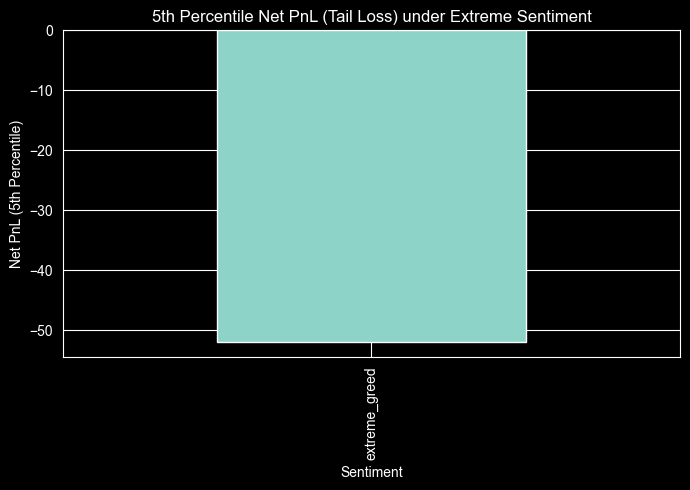

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
tail_loss.plot(kind="bar")

plt.title("5th Percentile Net PnL (Tail Loss) under Extreme Sentiment")
plt.ylabel("Net PnL (5th Percentile)")
plt.xlabel("Sentiment")
plt.tight_layout()

plt.savefig(
    OUTPUT_DIR / "tail_loss_extreme_sentiment.png",
    dpi=150
)

plt.show()

In [88]:
exposure_extreme = (
    extreme_df.groupby("sentiment")["abs_size_usd"]
              .mean()
)

exposure_extreme

sentiment
extreme_greed    5660.265764
Name: abs_size_usd, dtype: float64

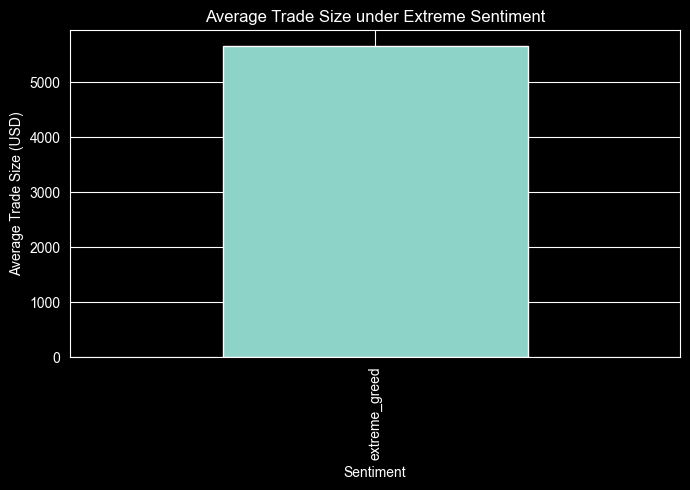

In [89]:
plt.figure(figsize=(7,5))
exposure_extreme.plot(kind="bar")

plt.title("Average Trade Size under Extreme Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.xlabel("Sentiment")
plt.tight_layout()

plt.savefig(
    OUTPUT_DIR / "exposure_extreme_sentiment.png",
    dpi=150
)

plt.show()

In [90]:
stability_check = (
    extreme_df.groupby("sentiment")["net_pnl"]
              .agg(mean="mean", median="median")
)

stability_check

,mean,median
sentiment,,
extreme_greed,24.440205,0.045985


In [91]:
cluster_extreme_perf = (
    extreme_df.dropna(subset=["cluster_label"])
              .groupby(["cluster_label", "sentiment"])["net_pnl"]
              .quantile(0.05)
              .unstack()
)

cluster_extreme_perf

sentiment,extreme_greed
cluster_label,
Aggressive Size Traders,-50.516918
Conservative Traders,-0.523432
High-Risk Gamblers,-18.973231
Overtraders,-21.539173


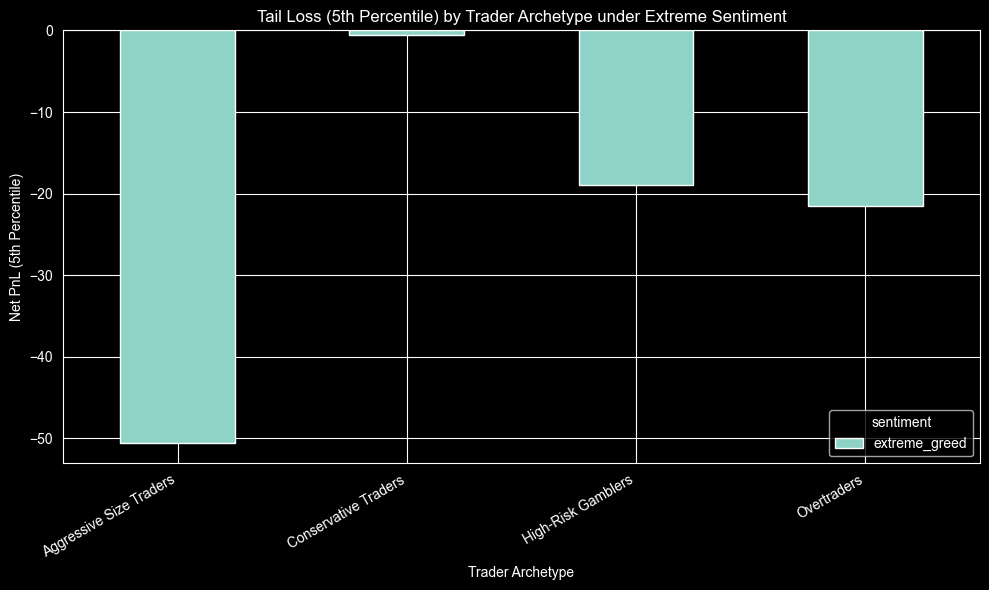

In [92]:
plt.figure(figsize=(10,6))

cluster_extreme_perf.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Tail Loss (5th Percentile) by Trader Archetype under Extreme Sentiment")
plt.ylabel("Net PnL (5th Percentile)")
plt.xlabel("Trader Archetype")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

plt.savefig(
    OUTPUT_DIR / "cluster_tail_loss_extreme_sentiment.png",
    dpi=150
)

plt.show()